In [628]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler

In [629]:
data = pd.read_csv("kickstarter.csv")
data['success_rate'] = data['pled'] / data['goal'] * 100

In [630]:
def del_n_sigmas_emissions(df, col_name, n_sigmas=3) -> DataFrame:
    len_was = df.shape[0]
    std = df[col_name].std()
    mean = df[col_name].mean()
    result = df[(df[col_name] >= mean - std * n_sigmas) & (df[col_name] <= mean + std * n_sigmas)]
    #print(f'{col_name}: {len_was - result.shape[0]} lines deleted')
    return result    

In [631]:
df = data.copy()

# Using 3 sigmas rule
df = del_n_sigmas_emissions(df, 'created')
df = del_n_sigmas_emissions(df, 'n_pled_t')
df = del_n_sigmas_emissions(df, 'goal')
df = del_n_sigmas_emissions(df, 'period')
#draw_scatter(df, 'goal')
len_was = df.shape[0]
df = df[df['goal'] > 15]
#print('goal < 15:', len_was - df.shape[0])
df = del_n_sigmas_emissions(df, 'success_rate')
df = del_n_sigmas_emissions(df, 'mgp')
df = del_n_sigmas_emissions(df, 'n_img')

In [632]:
df["text_am_2"] = df["text_am"] ** 2
df["n_img_2"] = df["n_img"] ** 2
df["n_vid_2"] = df["n_vid"] ** 2
df["created_2"] = df["created"] ** 2
df["cont_2"] = df["cont"] ** 2
df["mgp_2"] = df["mgp"] ** 2
df["n_pled_t_2"] = df["n_pled_t"] ** 2
df["period_2"] = df["period"] ** 2
df["step_pled_t_2"] = df["step_pled_t"] ** 2
df['bias'] = np.ones((df.shape[0]))

In [633]:
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure']

In [634]:
our = ['text_am', 'text_am_2', 'n_vid', 'cont', 'mgp', 'n_vid_2', 'mgp_2', 'cont_2']
# step_pled_t_2 и n_img_2 имеют положительные коэффиценты

In [635]:
result = our + binary_columns

In [636]:
X = df[our]
Y = df["success_rate"]

scaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    train_size=0.8, 
                                                    random_state=42)

train_data = scaler.fit_transform(X_train)
test_x_data = scaler.transform(X_test)
test_y_data = Y_test

In [637]:
ols = sm.OLS(df['success_rate'], df[our])
res = ols.fit()

results_as_html = res.summary().tables[1].as_html()
summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           success_rate   R-squared (uncentered):                   0.368
Model:                            OLS   Adj. R-squared (uncentered):              0.368
Method:                 Least Squares   F-statistic:                              559.7
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                        0.00
Time:                        14:51:48   Log-Likelihood:                         -44099.
No. Observations:                7692   AIC:                                  8.821e+04
Df Residuals:                    7684   BIC:                                  8.827e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
text_am        0.0066      0.003      2.441      0.015       0.001       0.012
text_am_2  -1.117e-06   7.09e-07     -1.574      0.115   -2.51e-06    2.74e-07
n_vid         38.7179      1.303     29.720      0.000      36.164      41.272
cont          70.5143     20.167      3.496      0.000      30.981     110.048
mgp            3.3707      1.048      3.218      0.001       1.317       5.424
n_vid_2       -3.5621      0.178    -19.963      0.000      -3.912      -3.212
mgp_2         -0.2448      0.087     -2.802      0.005      -0.416      -0.074
cont_2       -19.1971     47.266     -0.406      0.685    -111.850      73.456
==============================================================================
Omnibus:                     5527.637   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           105714.220
Skew:                           3.275   Prob(JB):                         0.00
Kurtosis:                      19.939   Cond. No.                     2.20e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [638]:
#for col in ['text_am', 'n_vid', 'mgp']:
    #col_sqr = col + '_2'
    #def func(x):
        #return summary_df['coef'][col] * x + summary_df['coef'][col_sqr] * x ** 2

    #plt.figure(figsize=(14,10))
    #plt.plot(df.sort_values(by=[col])[col], func(df.sort_values(by=[col])[col]), label='linear regression',
         #color='#BF2D00', 
         #lw=2,
         #linestyle='-')
    #plt.scatter(df.sort_values(by=[col])[col], func(df.sort_values(by=[col])[col]), label='linear regression',
         #color='#BF2D00')
    #plt.xlabel(f'Значение {col}', fontsize=20)
    #plt.ylabel(f'Значение success_rate в %', fontsize=20)
#summary_df['coef']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kep

text_am       0.006600
text_am_2    -0.000001
n_vid        38.717900
cont         70.514300
mgp           3.370700
n_vid_2      -3.562100
mgp_2        -0.244800
cont_2      -19.197100
Name: coef, dtype: float64

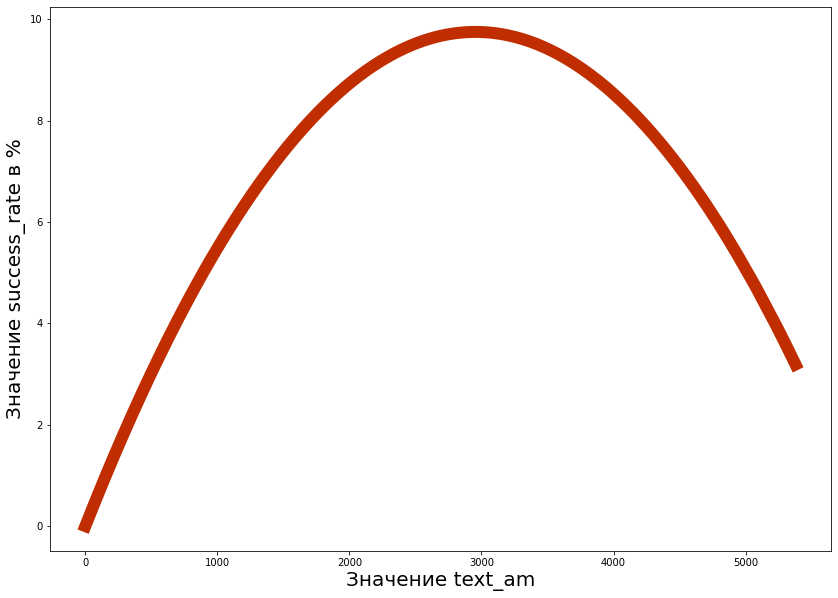

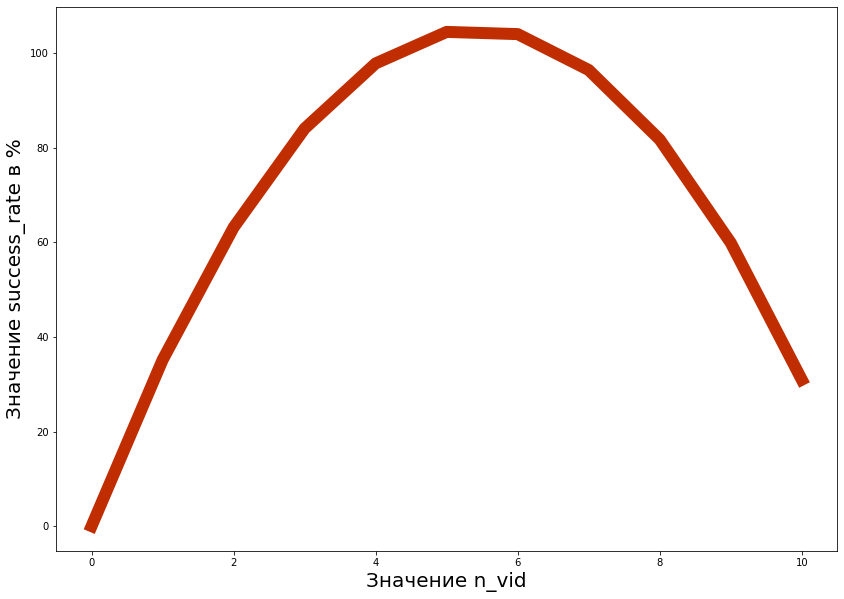

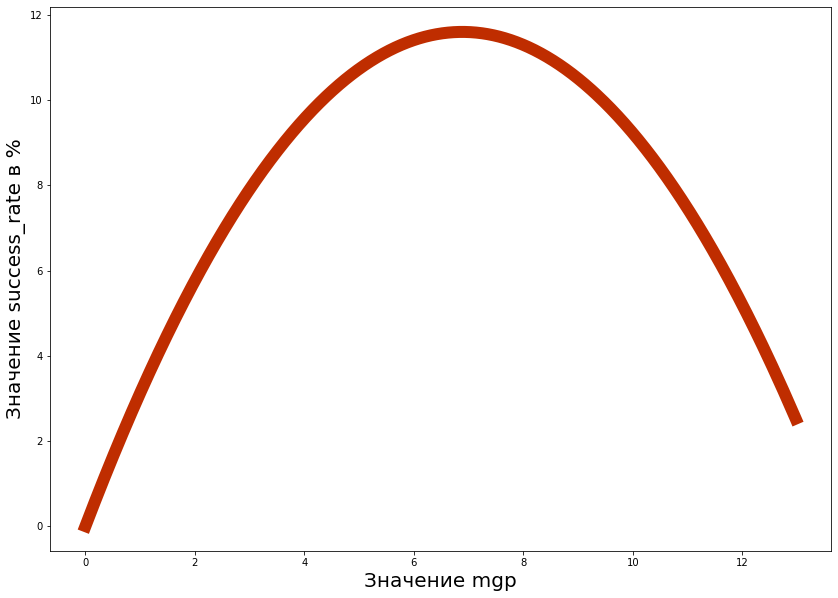

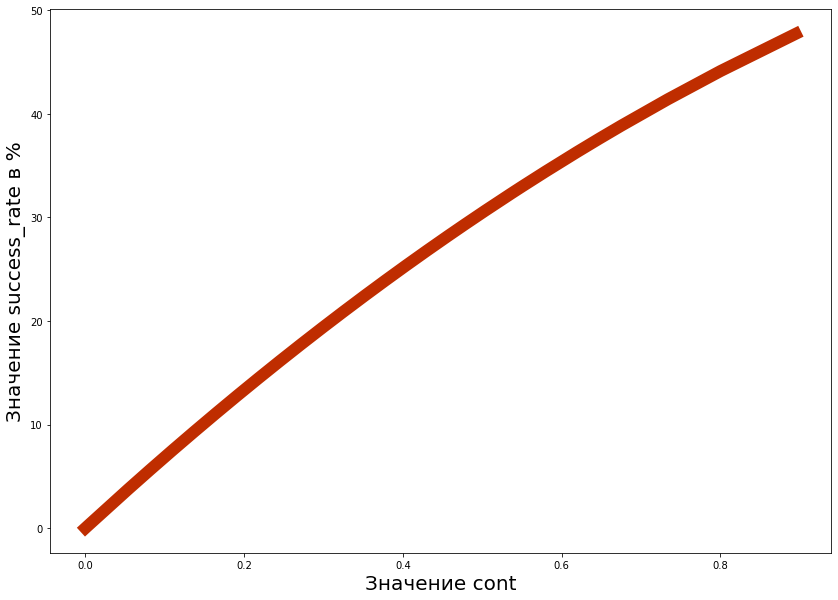

In [639]:
df["text_am"] = df[df["text_am"] < 5500]["text_am"]
df["n_vid"] = df[df["n_vid"] < 11]["n_vid"]
df["mgp"] = df[df["mgp"] < 13]["mgp"]

for col in ['text_am', 'n_vid', 'mgp', "cont"]:
    col_sqr = col + '_2'
    def func(x):
        return summary_df['coef'][col] * x + summary_df['coef'][col_sqr] * x ** 2

    plt.figure(figsize=(14,10))
    plt.plot(df.sort_values(by=[col])[col], func(df.sort_values(by=[col])[col]), label='linear regression',
         color='#BF2D00', 
         lw=2,
         linestyle='-', linewidth = 12)
    #plt.scatter(df.sort_values(by=[col])[col], func(df.sort_values(by=[col])[col]), label='linear regression',
         #color='#BF2D00', linewidths = 12)
    plt.xlabel(f'Значение {col}', fontsize=20)
    plt.ylabel(f'Значение success_rate в %', fontsize=20)
summary_df['coef']